# WEED Inference
This notebook demonstrates how we integrate Earth Observation (EO) data processing with ONNX-based machine learning (ML) inference within the WEED framework.

Overview of the Process
1) Loading Data Cube:
We start by loading a data cube that contains all the enabled training features as individual bands. This lazy loading approach ensures efficient memory usage during data processing.

2) Model Metadata Retrieval:
The models are stored in an openEO-accessible storage site. Each model contains metadata specifying the features it was trained on.

Important Note: Users must add this metadata to the stored models.
The onnx_model_utilities module provides a utility function to extract metadata from a JSON file and embed it into the ONNX model. This approach is temporary and will be replaced as model training becomes fully integrated within the WEED framework.

In [1]:
import os
import sys
import openeo
import datetime

from pathlib import Path

sys.path.append(os.path.abspath('C:/Git_projects/eo_processing/src'))

from eo_processing.utils.helper import init_connection, getUDFpath
from eo_processing.utils.onnx_model_utilities import get_training_features_from_model
from pathlib import Path

from eo_processing.openeo.processing import generate_master_feature_cube
from eo_processing.config import get_collection_options,  get_standard_processing_options

## Step 1: Connect to openEO Processing Backend
To begin, we establish a connection to the openEO backend. This connection is essential for accessing and processing EO data.

In [2]:
backend = 'cdse' 
# establish the connection to the selected backend
connection = init_connection(backend)
collection_options = get_collection_options(provider=backend)

# We call again the standard processing options for feature generation
processing_options = get_standard_processing_options(provider=backend, task='feature_generation')


Authenticated using refresh token.


## Step 2: Specify Space and Time Context
Define the spatial and temporal parameters for the data cube. This step ensures that only relevant data is loaded and processed during inference.

Important note, the job options were seme-optimised in function of the input size. Larger extents, will have higher memory requirements.

In [14]:
# the time context is given by start and end date
start = '2021-01-01'
end = '2021-02-01'   # the end is always exclusive
AOI = {
    'east': 4841500,
    'south': 2808500,
    'west': 4821500,
    'north': 2828500,
    'crs': 'EPSG:3035'
}

#note these job options were optimised for the spatiotemporal extent given above

job_options = {'driver-memory': '500m',
 'driver-memoryOverhead': '2000m',

 'executor-memory': '2000m',
 'executor-memoryOverhead': '500m',
 'python-memory': '4000m',
 }


### Step 3: Parse the available models
We extract all model names available in the model folder of interest. This folder should be on a publically available repository such that openEO can download the models later on.



In [16]:
import boto3

# Load the JSON data from the file
MODEL_URL = "https://s3.waw3-1.cloudferro.com/swift/v1/ecdc-waw3-1-ekqouvq3otv8hmw0njzuvo0g4dy0ys8r985n7dggjis3erkpn5o/models/"

# Replace with your CloudFerro S3 endpoint and credentials
s3_endpoint = 'https://s3.waw3-1.cloudferro.com'
access_key = "xx"
secret_key = "yy"
bucket_name = 'ecdc-waw3-1-ekqouvq3otv8hmw0njzuvo0g4dy0ys8r985n7dggjis3erkpn5o' 
s3_directory = 'models'  # Path in the S3 bucket

session = boto3.session.Session()
s3_client = session.client('s3',
                            endpoint_url=s3_endpoint,
                            aws_access_key_id=access_key,
                            aws_secret_access_key=secret_key)

# List objects in the specified directory
response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=s3_directory)

# Filter and create a list of .onnx file names
onnx_files = []
if 'Contents' in response:
    MODELS_NAMES = [obj['Key'].split('/')[-1] for obj in response['Contents'] if obj['Key'].endswith('.onnx')]


### we subsample the amount of jobs

In [18]:
#MODELS_NAMES = MODELS_NAMES[0:2]
len(MODELS_NAMES)

23

### Step 4: Define the input cube

Here we create the input datacube for the ML network inference

In [19]:
# we link towards the used model

#create the progress graph for the feature cube
# define the S1/S2 processed feature cube (Note: do not set spatial extent since we had it over in the end)
data_cube = generate_master_feature_cube(connection,
                                            AOI,
                                            start,
                                            end,
                                            **collection_options,
                                            **processing_options)

# load the DEM from a CDSE collection
DEM = connection.load_collection(
    "COPERNICUS_30",
    bands=["DEM"])
# reduce the temporal domain since copernicus_30 collection is "special" and feature only are one time stamp
DEM = DEM.reduce_dimension(dimension='t', reducer=lambda x: x.last(ignore_nodata=True))
# resample the cube to 10m and EPSG of corresponding 20x20km grid tile
DEM = DEM.resample_spatial(projection=processing_options['target_crs'],
                            resolution=processing_options['resolution'],
                            method="bilinear").filter_bbox(AOI)
# merge into the S1/S2 data cube
data_cube = data_cube.merge_cubes(DEM)

# load the WERN features from public STAC
WENR = connection.load_stac("https://stac.openeo.vito.be/collections/wenr_features")
# resample the cube to 10m and EPSG of corresponding 20x20km grid tile
WENR = WENR.resample_spatial(projection=processing_options['target_crs'],
                                resolution=processing_options['resolution'],
                                method="near").filter_bbox(AOI)
# drop the time dimension
try:
    WENR = WENR.drop_dimension('t')
except:
    # workaround if we still have the client issues with the time dimensions for STAC dataset with only one time stamp
    WENR.metadata = WENR.metadata.add_dimension("t", label=None, type="temporal")
    WENR = WENR.drop_dimension('t')
    
# merge into the S1/S2 data cube
data_cube = data_cube.merge_cubes(WENR)


## Step 5: Multimodel inference.

Here we create and start an openeo job which performs the inference of all onnx models in the provided folder. 

As a next step we should eveluate wheter we prefer 1 logn running job over multiple parallel openEO jobs. 

In [20]:
cube_list = []
for i, modelname in enumerate(MODELS_NAMES):
    model_url = MODEL_URL + modelname
    model_str = Path(modelname).stem + '_'

    metadata = get_training_features_from_model(model_url)

    input_bands = metadata['input_features']
    output_bands = metadata['output_features']
    output_bands = [model_str + prob for prob in output_bands]

    data_cube_model = data_cube.filter_bands(input_bands)

    #we pass the model url as context information within the UDF
    udf  = openeo.UDF.from_file(
            getUDFpath('udf_catboost_inference.py'),
            context={
                "model_url": model_url
                    }
    )

    # Apply the UDF to the data cube.
    catboost_classification = data_cube_model.apply_dimension(
        process=udf, dimension = "bands")
    

    output = catboost_classification.rename_labels(dimension="bands",target= output_bands)
     
    output = output.linear_scale_range(0,100, 0,100)

    #Save each band as a seperate tiff file
    save_result_options = {}
    save_result_options["separate_asset_per_band"] = True
    result_datacube = output.save_result(
                format="GTiff",
                options = save_result_options)
    
    # Get current datetime

    
    file_path = "test/" + model_str + datetime.datetime.now().strftime("%y_%m_%d_%H_%M_%S")
    

    result_datacube = result_datacube.process(
        "export_workspace",
        arguments={
            "data": result_datacube,
            "workspace": "esa-weed-workspace",
            "merge": file_path,  # this determines the folder structure on the s3 bucket
        },
    )
    
    cube_list.append(result_datacube)

#create and run the job
job = connection.create_job(cube_list,
    additional=job_options,
)

job.start_and_wait()

Loaded ONNX model from /tmp/cache\Level1_class-0_129predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level2_class-C_71predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level2_class-D_68predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level2_class-E_85predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level2_class-F_90predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level2_class-G_164predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level2_class-H_65predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level2_class-I_50predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level2_class-J_62predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level2_class-X_54predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level3_class-C1_62predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level3_class-C3_62predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level3_class-E1_50predictors_v1.onnx
Loaded ONNX model from /tmp/cache\Level3_class-E2_50predictors_v1.onnx
Loaded ONNX mo

<BatchJob job_id='j-2501089943c24778bcaf0578e09880ab'>

In [9]:
file_path

'test/Level2_class-F_90predictors_v1_25_01_08_13_05_54'

### Step 6: Download the results and plot the output

Rescaled Minimum Value: 1
Rescaled Maximum Value: 86


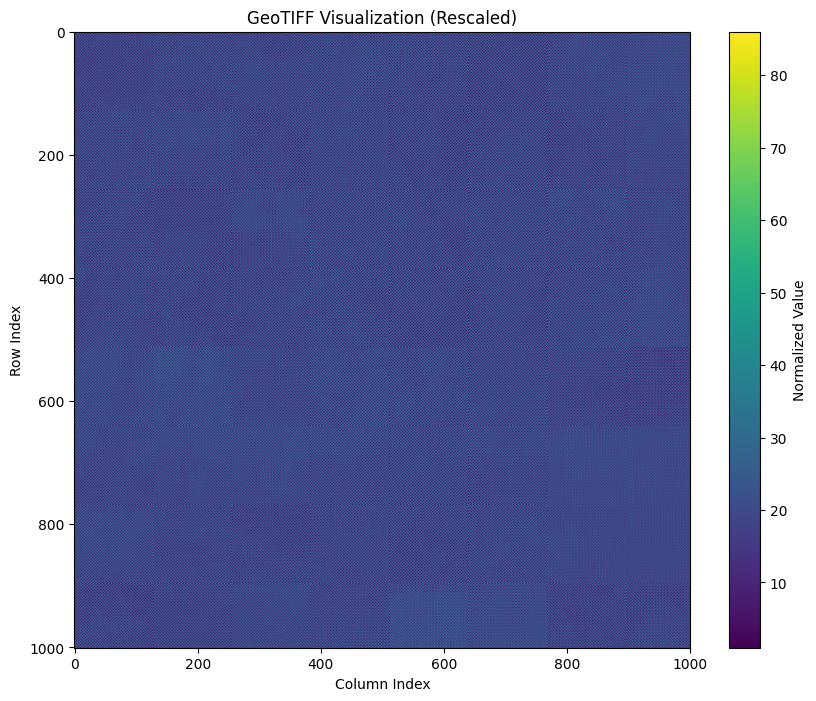

In [17]:

results = job.get_results()
results.download_files("C:/Git_projects/eo_processing/notebooks/output")

import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Path to your Cloud Optimized GeoTIFF
cog_path = 'C:/Git_projects/eo_processing/notebooks/output/openEO_Level2_class-F_90predictors_v1_60400.tif'

# Open the GeoTIFF
with rasterio.open(cog_path) as dataset:
    # Read the data
    data = dataset.read(1)  # Reading the first band (adjust as necessary)


    # Rescale the data between 0 and 1

    # Print min and max values of the rescaled data
    print(f"Rescaled Minimum Value: {np.min(data)}")
    print(f"Rescaled Maximum Value: {np.max(data)}")

    # Plot the rescaled data
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap='viridis')
    plt.colorbar(label='Normalized Value')
    plt.title("GeoTIFF Visualization (Rescaled)")
    plt.xlabel("Column Index")
    plt.ylabel("Row Index")
    plt.show()

